In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.nn.functional as func
#torch.manual_seed(50)




print(torch.__version__, torchvision.__version__)

print (torch.cuda.get_device_name(device='cuda:0'))

/home/kjb/.conda/envs/lora/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1+cu113 0.13.1+cu113
NVIDIA RTX A5000


In [2]:
# dst = datasets.CIFAR100("~/.torch", download=True)
# dst = datasets.MNIST("~/.torch", download=True)

tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cuda


In [3]:
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#         nn.init.xavier_uniform_(m.weight.data)
#     if hasattr(m, "bias"):
#         #m.bias.data.uniform_(-0.5, 0.5)
#         #nn.init.xavier_uniform(m.bias.data)
#         m.bias.data.fill_(0)



# class LeNet(nn.Module):

#     def __init__(self):

#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5,stride=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=2)
#         self.fc1 = nn.Linear(16*5*5, 256)
#         self.fc2 = nn.Linear(256, 120)
#         self.fc3 = nn.Linear(120, 106)

#     def forward(self, x):
#         #x = func.relu(self.conv1(x))
#         x = func.sigmoid(self.conv1(x))
#         #x = func.max_pool2d(x, 2)
#         #x = func.relu(self.conv2(x))
#         x = func.sigmoid(self.conv2(x))
#         #x = func.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         #x = func.relu(self.fc1(x))
#         x = func.sigmoid(self.fc1(x))
#         #x = func.relu(self.fc2(x))
#         x = func.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

    
    
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.3, 0.3)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.3, 0.3)

torch.manual_seed(50)

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
def weights_init_dropout(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.1, 0.1)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.1, 0.1)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        #act = nn.Tanh
        #act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
                nn.Linear(768, 106),
                 nn.Dropout(p=0.0)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

    

net = LeNet().to(device)
net.apply(weights_init)


# class LeNet_att(nn.Module):
#     def __init__(self):
#         super(LeNet_att, self).__init__()
#         act = nn.Sigmoid
#         #act = nn.Tanh
#         #act = nn.ReLU
#         self.body = nn.Sequential(
#             nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#         )
#         self.fc = nn.Sequential(
#                 nn.Linear(768, 106)
#         )
        
#     def forward(self, x):
#         out = self.body(x)
#         out = out.view(out.size(0), -1)
#         # print(out.size())
#         out = self.fc(out)
#         return out

# net_att = LeNet_att().to(device)
# net_att.apply(weights_init_dropout)
    
#criterion = cross_entropy_for_onehot
criterion = nn.CrossEntropyLoss()

In [4]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
lfw_people=fetch_lfw_people(min_faces_per_person=14,color=True,slice_=(slice(61,189),slice(61,189)),resize=0.25)
x=lfw_people.images
y=lfw_people.target

target_names=lfw_people.target_names
n_classes=target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,shuffle=False)


# #two people
# X_train_two = []
# y_train_two = []
# X_test_two = []
# y_test_two = []
# for ct_d in range(X_train.shape[0]):
#     if  y_train[ct_d] == 6:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(1)
        
# for ct_d in range(X_test.shape[0]):
#     if  y_train[ct_d] == 6:        
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(1)
        
# X_train = np.asarray(X_train_two)    
# X_test = np.asarray(X_test_two)  
# y_train = np.asarray(y_train_two)  
# y_test = np.asarray(y_test_two)  

print (X_train.shape)
print (X_test.shape)

         
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
#X_train = torch.transpose
#X_train = X_train.astype('float32')
X_train /= 255.0
X_test /= 255.0

 


x_train = torch.FloatTensor(X_train).to(device)
x_train = x_train.transpose(2,3).transpose(1,2)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
x_test = x_test.transpose(2,3).transpose(1,2)
y_test = torch.LongTensor(y_test).to(device)


training = data.TensorDataset(x_train,y_train)

testing = data.TensorDataset(x_test,y_test)

dst_tensor=training

criterion_train = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
trainloader = torch.utils.data.DataLoader(training,batch_size=32, shuffle=True)

(2801, 32, 32, 3)
(934, 32, 32, 3)


In [5]:
iter_ = 0


for epoch in range(100):

    for i,data in enumerate(trainloader,0):
   
        #if epoch>=1:
        if i==1:
            #break
            iter_=iter_+1
            #print (iter_)
            inputs,label = data

            inputs,label =  Variable(inputs),Variable(label) 

            optimizer_train.zero_grad()


            outputs_benign=net(inputs)
            #outputs_benign = F.softmax(outputs_benign, dim=-1)
            #print (outputs_benign[0])


            loss_benign =  criterion_train(outputs_benign,label)

            #print("loss computed")
            loss_benign.backward()
            #print("loss BP")
            optimizer_train.step()

            #if i%2000==0:
            print (loss_benign.item())
            #torch.save(net.state_dict(),'./LFW_net.pth')  
       
  
print ('fininshed training')
total = len(y_test)
acc =0.0
for ct in range(total):
    testing_data = tt(testing[ct][0].cpu())
    testing_data1 = tp(testing_data).to(device)
    testing_data2 = testing_data1.view(1, *testing_data1.size())
    y_pred = net(testing_data2)
    predicted = torch.argmax(y_pred)
  
    if predicted == y_test[ct]:
        acc=acc+1
accuracy = acc / total
print (accuracy)
print ('fininshed testing')


12.378009796142578
10.559222221374512
8.570782661437988
6.383893013000488
5.91531229019165
5.18739652633667
4.6573967933654785
4.434500217437744
4.665334224700928
4.842253684997559
4.631073474884033
4.671508312225342
4.666388511657715
4.586175441741943
4.571783065795898
4.633761882781982
4.5899200439453125
4.662527084350586
4.630593299865723
4.639894962310791
4.529384613037109
4.593671798706055
4.5451130867004395
4.503072261810303
4.515880107879639
4.381426811218262
4.34544563293457
4.3573317527771
4.218098163604736
4.182351112365723
4.84011173248291
4.417632579803467
4.494195938110352
3.965769052505493
4.330848693847656
4.337621688842773
4.214132785797119
4.329627990722656
4.359501838684082
4.464054107666016
4.350986480712891
4.013826847076416
4.194277286529541
4.344906806945801
4.385156154632568
4.603809833526611
4.211310863494873
4.1872453689575195
4.307382583618164
4.483173370361328
4.03753137588501
4.271254062652588
4.241307735443115
4.301805019378662
4.197465896606445
4.519602298

torch.Size([1, 3, 32, 32])
torch.Size([1, 1])
tensor([[60]], device='cuda:0')
torch.Size([1, 106])


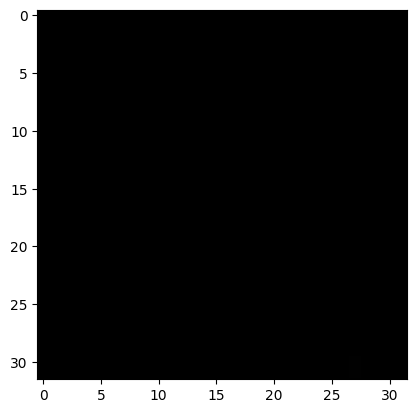

In [6]:

######### honest partipant #########
img_index = 13   #use img_index
dst_pil = tt(dst_tensor[img_index][0].cpu())   #use img_index

gt_data = tp(dst_pil).to(device)
gt_data = torch.unsqueeze(gt_data,0)

gt_label = dst_tensor[img_index][1].long().to(device) #use img_index
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=106)

plt.imshow(dst_pil)
#plt.savefig("./original/index_%s_label_%s"%(img_index,gt_label.item()))



batch =1  #
for bat in range(batch-1):
    dst_pil = tt(dst_tensor[img_index+1+bat][0].cpu())   #use img_index
    tmp = torch.unsqueeze(tp(dst_pil).to(device),0)
    #print(tmp.shape)
    gt_data = torch.cat((gt_data,tmp),0)
    
    gt_label_tmp = dst_tensor[img_index+1+bat][1].long().to(device) #use img_index
    gt_label_tmp = gt_label_tmp.view(1, )
    gt_label = torch.cat((gt_label,gt_label_tmp),0)
    gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=106)),0)
    
    if gt_label_tmp ==60:
        print (bat)

    plt.imshow(dst_pil)
    #plt.savefig("./original/index_%s_label_%s"%(bat+1,gt_label_tmp.item()))
    
    #plt.title("Ground truth image")
    #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    
gt_label = torch.reshape(gt_label,(-1,1))    
print (gt_data.shape)
print (gt_label.shape)
print (gt_label)
print (gt_onehot_label.shape)

plt.imshow(tt(gt_data[0].cpu()),cmap='gray')
# plt.axis('off')
# plt.savefig("./attack_image/tifs")


# compute original gradient 
dy_dx = []
original_dy_dx=[]
original_pred = []
for item in range(batch):
    gt_data_single = torch.unsqueeze(gt_data[item],0)
    out = net(gt_data_single)
    #y = criterion(out, gt_onehot_label[item])
    y = criterion(out, gt_label[item])
    dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
    original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    original_dy_dx.append(original_dy_dx_tmp)
    out_tmp = out.detach().clone()
    original_pred.append(out_tmp)
    
    
    #dy_dx.append(torch.autograd.grad(y, net.parameters()))

    
    
# #FOR fully-connected model only
#     dw = net.body[0].weight
#     db = net.body[0].bias
#     dy_dw = torch.autograd.grad(y, dw,retain_graph=True)
#     dy_db = torch.autograd.grad(y, db,retain_graph=True)

#     print (dy_dw)
#     #print (dy_db.shape)

#     leak=dy_dw/dy_db

#     print (leak.shape)
    


# share the gradients with other clients
#original_dy_dx = list((_.detach().clone() for _ in dy_dx))


Dummy label is 42.
stolen label is 60.
0.00058935
0.00002222
0.00000966
0.00000576
0.00000400
0.00000440
0.00000266
0.00000225
0.00000211
0.00000183
0.00000168
0.00000163
0.00000155
0.00000148
0.00000134
0.00000127
0.00000129
0.00000118
0.00000113
0.00000108
0.00000105
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
0.00000103
2.4121591567993166


<Figure size 640x480 with 0 Axes>

<Figure size 1200x150 with 0 Axes>

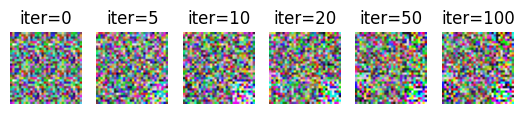

In [7]:
# generate dummy data and label
import time
 
from pytorch_msssim import ssim


#print (ssim(0.43*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),data_range=0).item())
#print (torch.dist(0.6*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),2).item())


for item in range(1):
    start = time.perf_counter()
    for rd in range(1):

        torch.manual_seed(200*rd)
        #dummy_data = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        #dummy_data = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
        #dummy_data = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)

        
        #background = torch.unsqueeze(torch.zeros(gt_data[item].size()),0)
        #background[0,0,::] = 1
        #dummy_data = background.to(device).requires_grad_(True)
        ##dummy_data = (torch.unsqueeze(torch.randn(gt_data[item].size()),0)+background).to(device).requires_grad_(True)
        
        #surrogate = torch.unsqueeze(gt_data[item+1],0)
        #aaa = torch.rand([3,16,16])
        #surrogate[0,:,8:24,8:24] =aaa
        #dummy_data = surrogate.to(device).requires_grad_(True)    
        
        #dummy_data = torch.unsqueeze(gt_data[item+1],0).to(device).requires_grad_(True)
        
        #k = np.random.randint(0,95)
        #dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
        
        
        pat_1 = torch.rand([3,16,16])
        pat_2 = torch.cat((pat_1,pat_1),dim=1)
        pat_4 = torch.cat((pat_2,pat_2),dim=2)
        dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)
        
        
        #aaa = torch.rand([3,8,8])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=1)
        #ddd = torch.cat((ccc,ccc),dim=2)
        #eee = torch.cat((ddd,ddd),dim=2)
        #dummy_data = torch.unsqueeze(eee,dim=0).to(device).requires_grad_(True)
        
        #aaa = torch.rand([3,4,4])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=1)
        #ddd = torch.cat((ccc,ccc),dim=1)
        #eee = torch.cat((ddd,ddd),dim=2)
        #fff = torch.cat((eee,eee),dim=2)
        #ggg = torch.cat((fff,fff),dim=2)
        #dummy_data = torch.unsqueeze(ggg,dim=0).to(device).requires_grad_(True)
        
        
        #dummy_data = plt.imread("./attack_image/replacement_69.png")
        #print (dummy_data.shape)
        #dummy_data = torch.FloatTensor(dummy_data).to(device)
        #dummy_data = dummy_data.transpose(2,3).transpose(1,2)
        
        dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)
        
        dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
        label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                dim=-1).detach().reshape((1,)).requires_grad_(False)
        #print (original_dy_dx[item][-1].shape)
        #print (original_dy_dx[item][-1].argmin())
        
        #print (torch.sum(original_dy_dx[item][-2], dim=-1).argmin())
        
        plt.imshow(tt(dummy_data[0].cpu()))
        plt.title("Dummy data")
        #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

        plt.clf()
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        print("stolen label is %d." % label_pred.item())
        
        
        #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
        optimizer = torch.optim.LBFGS([dummy_data,])
        #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)
        #optimizer = torch.optim.SGD([dummy_data,],lr=0.01)
      
       

        history = []
        
        percept_dis = np.zeros(300)
        recover_dis = np.zeros(300)
        for iters in range(300):
            
          
            #percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
            #recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()
           
            history.append(tt(dummy_data[0].cpu()))
            def closure():
                optimizer.zero_grad()

                pred = net(dummy_data) 
                
                #dummy_onehot_label = F.softmax(dummy_label, dim=-1).long()
                
                #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                ##print (pred)
                ##print (label_pred)
            
                dummy_loss = criterion(pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                ##dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                ##print (dummy_dy_dp[0].shape)  

                grad_diff = 0
                grad_count = 0
                #count =0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                   
                    #if iters==500 or iters== 1200:
                    #print (gx[0])
                    #    print ('hahaha')
                    #print (gy[0])
                    lasso = torch.norm(dummy_data,p=1)
                    ridge = torch.norm(dummy_data,p=2)
                    grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                    
                    #print (gx.shape)

                    grad_count += gx.nelement()
                

                    #if count == 9:
                    #    break
                    #count=count+1
                # grad_diff = grad_diff / grad_count * 1000
                
                #grad_diff += ((original_pred[item]-pred)**2).sum()
               
                
                
                
                grad_diff.backward()
                #print (count)

                #print (dummy_dy_dx)
                #print (original_dy_dx)


                return grad_diff



            optimizer.step(closure)
            if iters % 5 == 0: 
                current_loss = closure()
                #if iters == 0: 
                print ("%.8f" % current_loss.item())
                #print(iters, "%.8f" % current_loss.item())
            history.append(tt(dummy_data[0].cpu()))

        
        
        #plt.figure(figsize=(18, 12))
        #for i in range(60):
        #  plt.subplot(6, 10, i + 1)
        #  plt.imshow(history[i * 5])
        #  plt.title("iter=%d" % (i * 5))
        #  plt.axis('off')
        
        plt.figure(figsize=(12, 1.5))
        #iter_idx = [0,20,40,60,80,100,120,140,160,180]
        plt.figure(figsize=(6.5, 1.2))
        #iter_idx = [0,1000,2000,3000,4000,5000]
        iter_idx = [0,5,10,20,50,100]
        

        for i in range(6):
          plt.subplot(1, 6, i + 1)
          plt.imshow(history[iter_idx[i]])
          plt.title("iter=%d" % (iter_idx[i]))
          plt.axis('off')
            
        #np.savetxt('ssim_random2',percept_dis,fmt="%4f")
        #np.savetxt('mse_random2',recover_dis,fmt="%4f")
        
        #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        plt.savefig("./attack_image/index_%s_rand_%s_label_%s"%(item,rd, label_pred.item()))
        #plt.clf()
       
    duration = time.perf_counter()-start
    #print ("Running time is %.4f." %(duration/10.0) )
    print (duration/10.0 )
    
        

Dummy label is 42.


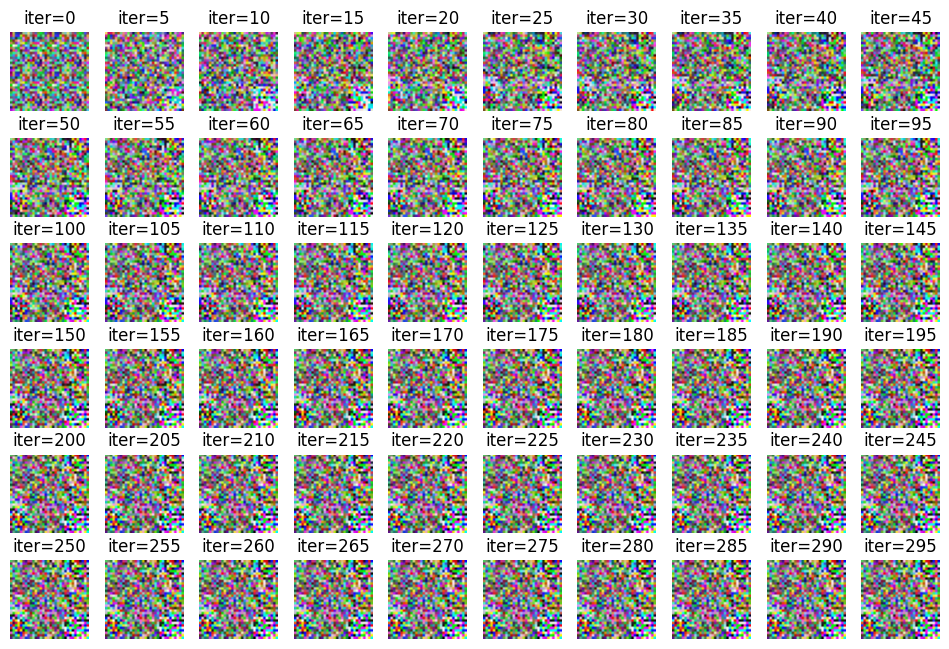

In [8]:
plt.figure(figsize=(12, 8))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history[i * 5])
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

NameError: name 'history_batch' is not defined

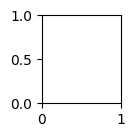

In [9]:
plt.figure(figsize=(12, 8))
for j in range(batch):
    for i in range(60):
      plt.subplot(6, 10, i + 1)
      plt.imshow(history_batch[i * 5+j])
      plt.title("iter=%d" % (i * 5+ j))
      plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())